In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium

import ast

%matplotlib inline


In [2]:
'''This function reads the raw data and cleans the data based on basic criteria. '''
def basic_cleaning():
    #read raw data file
    data = pd.read_csv('data/trip_dataset.csv')
    
#     #sample small data to test code BUT comment out for final script
#     data = data.sample(1000)

    #store original number of observation 
    data_TripNumber_original = len(data)


    
    #---------------------------------------------------------------------------------------------------------------
    #CONVERT START AND END DATE AND TIME TO PANDAS DATETIME FORMAT
    #drop row with null startDateTime and endDateTime
    data = data.dropna(subset = ['startDate','startTime','endDate','endTime'])
    data['startDateTime']=data.apply(lambda x: pd.to_datetime(x['startDate'][:10]+ ' ' + x['startTime'][:8], 
                                                              format='%Y-%m-%d %H:%M:%S'), axis=1)
    data['endDateTime']=data.apply(lambda x: pd.to_datetime(x['endDate'][:10]+ ' ' + x['endTime'][:8], 
                                                            format='%Y-%m-%d %H:%M:%S'), axis=1)

    #data['pubTimeStamp_pd'] = data.apply(lambda x: pd.to_datetimetime(x['pubTimeStamp'], format='%Y-%m-%d %H:%M:%S'), axis=1)

    

    
    #------------------------------------------------------------------------------------------------------------------
    #SLICE DATA FROM 
    data = data.loc[(data['startDateTime']>'2018-9-01') & (data['startDateTime']<'2019-8-31')]
    data_TripNumber_sliced_removed = len(data) 
    
    #------------------------------------------------------------------------------------------------------------------
    #PRELIMINARY DATA CLEANING
    
    #REMOVE MISSING VALUES
    #drop na variables and store remaining number of observation 
    data = data.dropna()
    data_TripNumber_NAN_sliced_removed = len(data)
    
    
    #remove trips whose trip duration is less than 1 minutes and more than 180 minutes (inlusive)
    data = data[data['tripDuration'].between(1,180)]
    data_TripNumber_NAN_sliced_duration_removed = len(data)

    #remove trips whose trip distance is less than 200 ft and more than greater than 52800 (10 mile) (inlusive)
    data = data[data['tripDistance'].between(200,52800)] #five miles
    data_TripNumber_NAN_sliced_duration_distance_removed = len(data) 

    #remove observation with too few GPS trace data
    data = data[data['tripRoute'].str.len()>10]
    data_TripNumber_NAN_sliced_duration_distance_fewGPSpoints_removed = len(data) 


    #DATA CLEANING BECAUSE OF SOME GLITCH
    #remove special character ("") from the data
    data['tripRoute'] = data.apply(lambda x: x['tripRoute'].strip().replace('"',''), axis=1)



    #drop columns
    data = data.drop(columns=['startDate','startTime','endDate','endTime','create_dt','pubTimeStamp'])
    
    #rename index column as trip ID
    data =data.reset_index().rename(columns={'index':'trip_id'})


    data_count={'original number of trips':data_TripNumber_original,
               'number of trips removed during slicing':data_TripNumber_original - data_TripNumber_sliced_removed,
                 'number of trips removed due to missing values': data_TripNumber_sliced_removed - data_TripNumber_NAN_sliced_removed,
               'total number of trips after slicing':data_TripNumber_NAN_sliced_removed,
               'number of trips removed due to duration criteria':data_TripNumber_NAN_sliced_removed - data_TripNumber_NAN_sliced_duration_removed,
               'number of trips removed due to distance criteria':data_TripNumber_NAN_sliced_duration_removed - data_TripNumber_NAN_sliced_duration_distance_removed,
               'number of trips removed due to few GPS trips':data_TripNumber_NAN_sliced_duration_distance_removed - data_TripNumber_NAN_sliced_duration_distance_fewGPSpoints_removed,
                'total number of trips after cleaning':data_TripNumber_NAN_sliced_duration_distance_fewGPSpoints_removed
               }

    return data, data_count


In [5]:
import time
start_time = time.time()

#call function to read and clean the data
(data, count) = basic_cleaning()

elapsed_time = time.time() - start_time
print("execution time: ",elapsed_time)

execution time:  398.4425091743469


In [6]:
data.head()

,trip_id,companyName,tripRecordNum,sumdID,tripDuration,tripDistance,startLatitude,startLongitude,endLatitude,endLongitude,tripRoute,startDateTime,endDateTime
0,9,Bird,BRD4,PoweredUNKWN,7.0,7007.87424,36.1651,-86.7785,36.1622,-86.7683,"[[36.165096,-86.778367],[36.165091,-86.778374]...",2018-09-01 12:13:22,2018-09-01 12:20:14
1,10,Bird,BRD8,PoweredUNKWN,35.0,22473.75400,36.1760,-86.7871,36.1733,-86.7857,"[[36.176036,-86.787034],[36.176036,-86.787034]...",2018-09-01 12:14:46,2018-09-01 12:49:27
2,11,Bird,BRD9,PoweredUNKWN,37.0,26912.73052,36.1643,-86.7770,36.1750,-86.7819,"[[36.164271,-86.777062],[36.164271,-86.777062]...",2018-09-01 12:15:11,2018-09-01 12:51:44
3,12,Bird,BRD10,PoweredUNKWN,21.0,278.87140,36.1642,-86.7811,36.1647,-86.7803,"[[36.164203,-86.78109],[36.164203,-86.78109],[...",2018-09-01 12:46:21,2018-09-01 13:07:25
4,13,Bird,BRD12,PoweredUNKWN,52.0,23182.41544,36.1643,-86.7771,36.1749,-86.7819,"[[36.164336,-86.777085],[36.164336,-86.777085]...",2018-09-01 12:18:32,2018-09-01 13:10:33


In [7]:
#summary of removed data points at key cleaning steps
count

{'original number of trips': 1570815,
 'number of trips removed during slicing': 23895,
 'number of trips removed due to missing values': 25711,
 'total number of trips after slicing': 1521209,
 'number of trips removed due to duration criteria': 127463,
 'number of trips removed due to distance criteria': 374488,
 'number of trips removed due to few GPS trips': 1808,
 'total number of trips after cleaning': 1017450}

### Save all trips in dataset

In [8]:
#save data with all column
data.to_csv('data/cleaned_trip_data.csv')
#save data without route data column
data.drop(columns=['tripRoute']).to_csv('data/cleaned_sampled_trip_data_withoutRouteData.csv')

### save sample dataset

In [13]:
#data.sample(400000).to_csv('data/400000_cleaned_sampled_trip_data.csv')
hundredThousandk_sample=data.sample(100000, random_state=0)
hundredThousandk_sample.to_csv('data/100000_cleaned_sampled_trip_data.csv')
hundredThousandk_sample.drop(columns=['tripRoute']).to_csv('data/100000_cleaned_sampled_trip_data_withoutRouteData.csv')

# Descriptive Statistics of all data

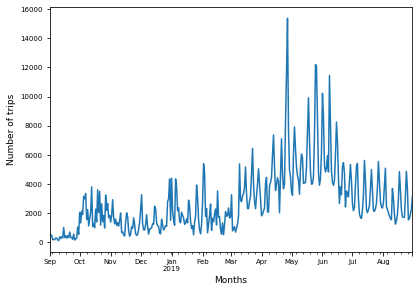

In [9]:
fig, ax = plt.subplots(figsize=(6.5,4.5))

data['startDateTime'].value_counts().resample('D').sum().plot.line(ax=ax)

#axis label
_ = plt.xlabel('Months', fontsize=9)    
_ = plt.ylabel('Number of trips', fontsize=9)  
_ = ax.tick_params(axis='both', which='major', labelsize=7)
_ = ax.tick_params(axis='both', which='minor', labelsize=7)

plt.savefig('results/DailyTrips_Year.png', dpi=900)

# Extracting March Data

In [11]:
#slice March data
data_summer_march = data.loc[(data['startDateTime']>'2019-3-5') & (data['startDateTime']<'2019-4-3')]

#create dummy variable for weekend trip (Saturday and Sunday)
data_summer_march['weekend_trip']=data_summer_march.apply(lambda x:1 if x['startDateTime'].weekday()>=5 else 0, axis=1)
data_summer_march['nonweekend_trip']=data_summer_march.apply(lambda x:1 if x['startDateTime'].weekday()<5 else 0, axis=1)

#save data
data_summer_march.to_csv('data/MarchMonthData_withRouteData.csv')
data_summer_march.drop(columns='tripRoute').to_csv('data/MarchMonthData_withoutRouteData.csv')

C:\Users\nshah12\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\nshah12\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Note: Merge landuse data in ArcGIS (codes/files not provided here). The final dataset is prepared in the next notebook.